In [11]:
import pandas as pd
import numpy as np
import random
import pickle
import os

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from helper_functions import *

Import data and drop selected features

In [3]:
with open('data/train_valid_test_data.pickle', 'rb') as f:
    train_df, valid_df, test_df = pickle.load(f)

''' 
Merge test and validation data.
'''
test_df = pd.concat([test_df,valid_df])

In [4]:
''' 
Drop features that have high percantage of missing values and 
have no noticable distribution differences.
'''

drop_cols = ["FiO2", "Bilirubin_direct", "SBP", "DBP", "Hct", "HospAdmTime", "ICULOS"] 

train_df.drop(train_df.columns[train_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
test_df.drop(test_df.columns[test_df.columns.str.contains('unnamed',case = False)],   axis = 1, inplace = True)
train_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)

In [6]:
print(train_df.shape)
print(test_df.shape)

(552371, 31)
(237844, 31)


In [7]:
def split_features_and_labels(df):
    cols = df.columns
    return np.array(df[cols[:-1]].values), df[cols[-1]].values

X_train, y_train = split_features_and_labels(train_df)
X_test, y_test   = split_features_and_labels(test_df)

Train Isolation Forest Model

In [8]:
# define outlier detection model
CONTAMINATION = 0.2
isolation_forest = IsolationForest(contamination = CONTAMINATION, verbose = True, n_jobs = 4, random_state = 2141)
 

X_train = X_train[y_train == 0]
isolation_forest.fit(X_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   10.7s remaining:   10.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   10.9s finished


IsolationForest(contamination=0.2, n_jobs=4, random_state=2141, verbose=True)

Evalute Model Performance

In [ ]:
''' 
Once fit, the model can be used to find outliers in data.

Model returns +1 ... inlier(Non Sepsis)
Model returns -1 ... outlier(Sepsis)
'''

X_test = test_df.loc[:, test_df.columns != "SepsisLabel"]
y_test = test_df["SepsisLabel"]
y_test[y_test == 1] = -1
y_test[y_test == 0] = +1

In [10]:
display_performance(isolation_forest, X_test, y_test)

C:\Users\matja\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


Accuarcy  = 0.792094818452431
Recall    = 0.8016748374788927
Precision = 0.982667270582287
F1Score   = 0.8829916873910049
F2Score   = 0.8323355590688312


In [13]:
'''
f1 score on sepsis positive patients
'''

score = f1_score(y_test, isolation_forest.predict(X_test), pos_label=-1)
print('F1 Score: %.3f' % score)

C:\Users\matja\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


F1 Score: 0.068


C:\Users\matja\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


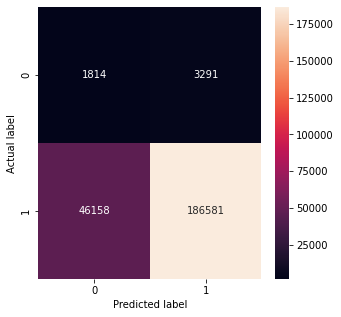

In [14]:
predictions  = isolation_forest.predict(X_test)
plot_cm(y_test, predictions)

Hyper-parameter Search

In [16]:
clf = IsolationForest(random_state = 47)

param_grid = {
              'n_estimators': list(range(100, 800, 100)), 
              'max_samples': list(range(100, 500, 100)), 
              'contamination': [0.1, 0.2, 0.3, 0.4, 0.5], 
              'max_features': [5,10,15], 
              'bootstrap': [True, False]
              }

selector = GridSearchCV(clf, 
                        param_grid,
                        scoring = "f1_micro", 
                        refit = True,
                        cv = 10, 
                        return_train_score=True,
                        n_jobs = 4,
                        verbose = True
                        ) 

best_isolation_forest = selector.fit(X_train, y_train)

In [17]:
with open("models/best_isolation_forest.pkl", "rb") as f:
    best_isolation_forest = pickle.load(f)

#with open("models/best_isolation_forest.pkl", "wb") as f:
#    pickle.dump(best_logreg,f)

In [18]:
print("Selected Hyper parameters")
print("Parameters: " + str(best_isolation_forest.best_params_))
print("F1 Score: " + str(best_isolation_forest.best_score_))

Selected Hyper parameters
Parameters: {'n_estimators': 100, 'max_samples': 300, 'max_features': 5, 'contamination': 0.1, 'bootstrap': True}
F1 Score: 0.016664523354793938


Evaluate Best Model

In [19]:
display_performance(best_isolation_forest, X_test, y_test)

Accuarcy  = 0.8870562217251644
Recall    = 0.9016580805107868
Precision = 0.9814101185075715
F1Score   = 0.9398452632875393
F2Score   = 0.9165544182211111


In [20]:
score = f1_score(y_test, best_isolation_forest.predict(X_test), pos_label=-1)
print('F1 Score: %.3f' % score)

F1 Score: 0.078


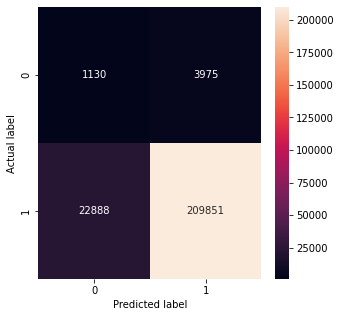

In [21]:
predictions  = best_isolation_forest.predict(X_test)
plot_cm(y_test, predictions)